## hetGPy Sequential Learning

This notebook illustrates the use of the `update` method in `hetGPy`.

Suppose we are interested in online learning, where we have a trained GP model, but we want to continually update our GP regression as we acquire new data, each time intializing the maximum likelihood estimation routine from our current set of GP hyperparameters.

In `hetGPy`, model updates are on the order of $O(n^2)$ which is faster than the full training size of $O(n^3)$ see [Binois and Gramacy (2021)](https://www.jstatsoft.org/article/view/v098i13) for details.

First, we import our libraries and setup a few helper functions.


In [1]:
import numpy as np
from hetgpy import hetGP
from hetgpy.test_functions import f1d
from copy import copy
from scipy.stats import norm
import os
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

rand = np.random.default_rng(42)

def noise_fun(x,coef=1):
    noise = coef * (1.1 + np.sin(2*np.pi*x))**2
    return noise

def f1d_n(x):
    '''f1d function with spatially varying noise'''
    noise_var = noise_fun(x)
    return f1d(x).squeeze() + rand.normal(loc = 0, scale = noise_var.squeeze(), size = len(x))

Next, we see up an online learning procedure where we gather new data along a moving window in $[0,1]$. Our data-generating process is noisy and nonstationary, so we will see higher noise for low values of $X$ and lower noise for high values of X. The true underlying function is the `f1d` function from [Forrester, Sobester, Keane (2008) Appendix](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470770801) 

where:
\begin{align*}
f(x) = (6x-2)^2 \sin{12x-4}
\end{align*}

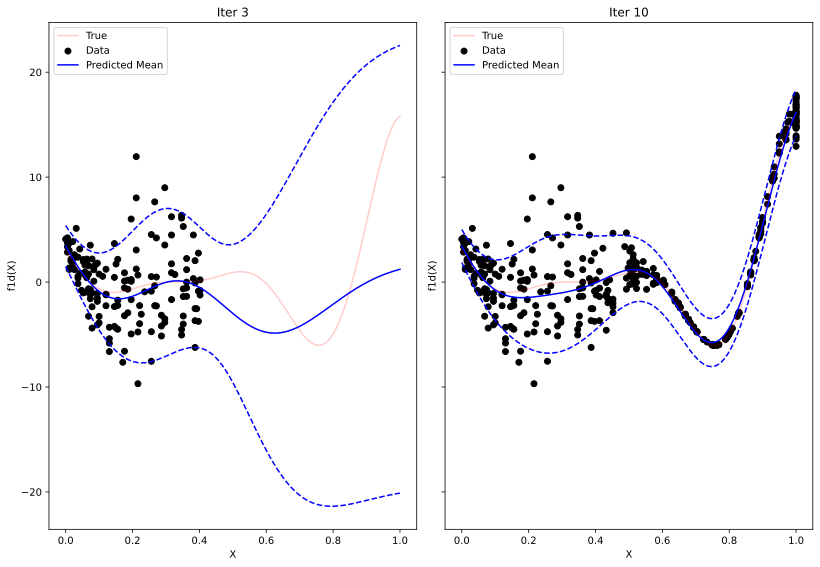

In [2]:
## Initial data set
nvar = 1
n    = 20
X    = np.linspace(0, 0.1,n).reshape(-1,1)
mult = rand.choice(np.arange(1,6),size = n, replace = True)
X    = np.vstack(np.repeat(X,mult,axis=0))

testpts = np.linspace(0,1,int(10*n))
Z       = f1d_n(X)
Ztrue   = f1d(testpts)

nsteps    = 10
npersteps = 10
step      = 1

interval_size = int(len(testpts)/nsteps)
interval      = np.arange(1,interval_size+1)


model = hetGP()
model.mle(
    X = X,
    Z = Z,
    lower = 0.1 + 0.0*np.arange(X.shape[1]),
    upper = 5 + 0.0*np.arange(X.shape[1]),
    maxit = 500,
    settings = {'checkHom':False}
)
model_init = copy(model)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize = (11.5,8),sharey=True)
for i in range(2):
    # plot true test function
    ax[i].plot(testpts.squeeze(),Ztrue,alpha=0.2,color='red',label = 'True')
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('f1d(X)')
    
for i in range(nsteps):
    
    interval = np.clip(interval + interval_size,a_min=None,a_max=len(testpts)-1)
    newIds   = sorted(rand.choice(interval,size=npersteps,replace = False))
    newmult  = rand.choice(np.arange(1,6),len(newIds), replace = True)
    newIds   = np.repeat(newIds,newmult)
    newX     = testpts[newIds].reshape(-1,1)
    newZ     = f1d_n(newX.squeeze())
    
    model.update(Xnew = newX, Znew = newZ)
    
    X = np.vstack([X,newX])        
    Z = np.hstack([Z,newZ.squeeze()])

    plot_steps = (2,nsteps-1)

    # show an early iteration and a later one
    if i in plot_steps:
        j = 0 if i == plot_steps[0] else 1
        ax[j].scatter(X.squeeze().copy(),Z.copy(), alpha = 1.0, color = 'black',label = 'Data')
        preds = model.predict(testpts.reshape(-1,1))
        preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
        preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze() 
        ax[j].plot(testpts.squeeze(),preds['mean'],color='blue',label='Predicted Mean')
        ax[j].plot(testpts.squeeze(),preds['lower'],color='blue',linestyle='dashed')
        ax[j].plot(testpts.squeeze(),preds['upper'],color='blue',linestyle='dashed')
        ax[j].set_title(f'Iter {i+1}')
        ax[j].legend(loc='upper left');

fig.tight_layout()